In [2]:
from dariah_topics import preprocessing as pre
from dariah_topics import visualization as visual
from dariah_topics import evaluation

## Preprocessing

#### Liste mit Dateinamen erzeugen

In [3]:
path_txt = "corpus_txt"
#path_txt = "grenzbote_plain/*/"
#path_txt = "wiki/"

doclist_txt = pre.create_document_list(path_txt)
assert doclist_txt, "No documents found"
doclist_txt[:5]

INFO preprocessing: Creating document list from TXT files ...


['corpus_txt/Howard_TheDevilinIron.txt',
 'corpus_txt/Poe_EurekaAProsePoem.txt',
 'corpus_txt/Doyle_AScandalinBohemia.txt',
 'corpus_txt/Poe_TheCaskofAmontillado.txt',
 'corpus_txt/Kipling_ThyServantaDog.txt']

#####  Liste mit Dokumentenlabels erzeugen - (Funktion wird durch Thorsten's generischere Funktion ersetzt)

In [4]:
doc_labels = list(pre.get_labels(doclist_txt))
doc_labels[:5]

INFO preprocessing: Creating document labels ...


['Howard_TheDevilinIron',
 'Poe_EurekaAProsePoem',
 'Doyle_AScandalinBohemia',
 'Poe_TheCaskofAmontillado',
 'Kipling_ThyServantaDog']

#### Corpus laden

In [5]:
corpus_txt = pre.read_from_txt(doclist_txt)

#### Tokenisieren

In [6]:
doc_tokens = [list(pre.tokenize(txt)) for txt in list(corpus_txt)]

INFO preprocessing: Accessing TXT documents ...


#### Create Dictionaries

In [7]:
id_types = pre.create_dictionary(doc_tokens)
doc_ids = pre.create_dictionary(doc_labels)

#### Sparse BOW Model

In [8]:
sparse_bow = pre.create_sparse_bow(doc_labels, doc_tokens, id_types, doc_ids)

In [9]:
sparse_bow[:5]

0
doc_id token_id   
1      16384     7
       16387     1
       7         1
       8         1
       16393     1

## Topic Modeling with Gensim

##### Saving Sparse BOW

In [10]:
pre.save_sparse_bow(sparse_bow, "gensim_txt")

#### Import Market Matrix

In [11]:
from gensim.models import LdaModel
from gensim.corpora import MmCorpus

In [12]:
mm = MmCorpus("gensim_txt.mm")

INFO gensim.matutils: initializing corpus reader from gensim_txt.mm
INFO gensim.matutils: accepted corpus with 17 documents, 22232 features, 369906 non-zero entries


In [13]:
doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

##### Remove Features

type2id = {value : key for key, value in id_types.items()}
sparse_bow_collapsed = sparse_bow.groupby(sparse_bow.index.get_level_values('token_id')).sum()

sparse_bow_hapax = sparse_bow_collapsed.loc[sparse_bow_collapsed[0] == 1]
hapax = [type2id[key] for key in sparse_bow_hapax.index.get_level_values('token_id')]

len(hapax)

In [14]:
import os.path
basepath = os.path.abspath('.')

with open(os.path.join(basepath, "tutorial_supplementals", "stopwords", "de.txt"), 'r', encoding = 'utf-8') as f: 
    stopword_list = f.read().split('\n')
    
stopword_list = set(stopword_list)

In [15]:
hapax_from_remove = pre.find_hapax(sparse_bow, id_types)
stopwords_from_remove = pre.find_stopwords(sparse_bow, id_types, mfw=75)

#features_to_be_removed = set(hapax_from_remove + stopwords_from_remove)
features_to_be_removed = stopwords_from_remove

sparse_bow_short = pre.remove_features(sparse_bow, id_types, features_to_be_removed)

INFO preprocessing: Finding hapax legomena ...
INFO preprocessing: Finding stopwords ...
INFO preprocessing: Removing features ...


In [16]:
pre.save_sparse_bow(sparse_bow_short, "gensim_txt")

In [17]:
mm = MmCorpus("gensim_txt.mm")

INFO gensim.matutils: initializing corpus reader from gensim_txt.mm
INFO gensim.matutils: accepted corpus with 17 documents, 22232 features, 192053 non-zero entries


#### Convert sparse_bow to list of (doc, tokens) tuples (like doc2bow)

In [18]:
doc2bow_list = []

for doc in sparse_bow_short.index.groupby(sparse_bow_short.index.get_level_values('doc_id')):
    temp = [(token, count) for token, count in zip(sparse_bow_short.loc[doc].index, sparse_bow_short.loc[doc][0])]
    doc2bow_list.append(temp)

In [19]:
len(doc2bow_list)

17

In [20]:
#model = LdaModel(corpus=mm, id2word=type2id, num_topics=60, alpha = "symmetric", passes = 10) #import momentan in visual 
# -> da ich mir noch nicht sicher bin, welche Funktionen in das tm_gensim.py sollen
model = LdaModel(corpus=mm, id2word=type2id, num_topics=20, iterations=10)

INFO gensim.models.ldamodel: using symmetric alpha at 0.05
INFO gensim.models.ldamodel: using symmetric eta at 4.49781855799937e-05
INFO gensim.models.ldamodel: using serial LDA version on this node
INFO gensim.models.ldamodel: running online LDA training, 20 topics, 1 passes over the supplied corpus of 17 documents, updating model once every 17 documents, evaluating perplexity every 17 documents, iterating 10x with a convergence threshold of 0.001000
WARNING gensim.models.ldamodel: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO gensim.models.ldamodel: -14.378 per-word bound, 21296.8 perplexity estimate based on a held-out corpus of 17 documents with 192053 words
INFO gensim.models.ldamodel: PROGRESS: pass 0, at document #17/17
INFO gensim.models.ldamodel: topic #0 (0.050): 0.004*"metaphysical" + 0.003*"popularizer" + 0.003*"misty" + 0.003*"dissimilar" + 0.003*"survived" + 0.003*"rock-chipping" + 0.003*"cry"

In [21]:
model.get_document_topics(doc2bow_list[0])

[(0, 0.029102042349062582),
 (1, 0.010309298425270523),
 (3, 0.01272993623327728),
 (4, 0.030025887193470015),
 (8, 0.054767268570920381),
 (9, 0.18288274792727705),
 (10, 0.078697771397684371),
 (11, 0.30961988016843756),
 (12, 0.026119114185567678),
 (13, 0.052562137206464597),
 (15, 0.16111250662552409),
 (16, 0.012785415430380706),
 (19, 0.012596383611591174)]

In [22]:
#Anzeige der keywords für topic n
n = 2
topic_nr_x = model.get_topic_terms(n)

topicTerms = [type2id[i[0]] for i in topic_nr_x]
topicTerms

['raises',
 'cry',
 'maximum',
 'dissimilar',
 'wastrel',
 "sholto's",
 'white-haired',
 'bandy',
 'race-descended',
 'begged']

In [23]:
#Topic probabilities - zum Testen der Funktion
topics = model.show_topics(num_topics = model.num_topics, formatted=False)

num_topics = model.num_topics
topics_df = pre.pd.DataFrame(index = range(num_topics), columns= range(10))

for topic in topics:
    idx = topic[0]
    temp = topic[1]
    topics_df.loc[idx] = temp
        
topics_df

,0,1,2,3,4,5,6,7,8,9
0,"(metaphysical, 0.00367913892344)","(popularizer, 0.00320240838005)","(misty, 0.00308984596043)","(dissimilar, 0.00295229366456)","(survived, 0.00280159566867)","(rock-chipping, 0.00275983825139)","(cry, 0.00271541527053)","(maximum, 0.00267109232748)","(sought, 0.00266928234782)","(mustaches, 0.00258347581707)"
1,"(mustaches, 0.00336198980266)","(survived, 0.00314782458608)","(metaphysical, 0.00310140468966)","(sholto's, 0.00290551894465)","(raises, 0.00283186981832)","(cry, 0.00253723488989)","(dissimilar, 0.00248592886674)","(lane, 0.00247207394036)","(illimitation, 0.00244971071279)","(bandy, 0.0024183525341)"
2,"(raises, 0.00310496542321)","(cry, 0.00303079242944)","(maximum, 0.00300234997263)","(dissimilar, 0.00289655082966)","(wastrel, 0.00282059706406)","(sholto's, 0.00271332527176)","(white-haired, 0.00269284920976)","(bandy, 0.00258149276018)","(race-descended, 0.00248162529903)","(begged, 0.00243745239512)"
3,"(popularizer, 0.00339445988349)","(survived, 0.00309420549869)","(raises, 0.00266947366494)","(quadrupeds, 0.00262486920344)","(mustaches, 0.00258887417147)","(illimitation, 0.0025588632561)","(metaphysical, 0.0025458626671)","(maximum, 0.00254207629375)","(sholto's, 0.00253340000257)","(weakness, 0.00238770682807)"
4,"(survived, 0.00331036965293)","(white-haired, 0.00315808071782)","(frightfully, 0.00312921812686)","(illimitation, 0.00311767078205)","(distorted, 0.00265846526998)","(metaphysical, 0.00264768429311)","(unsatiated, 0.00252880424208)","(lane, 0.00242354040217)","(divorce, 0.00242125426023)","(hush, 0.00241079951756)"
5,"(survived, 0.00299158837797)","(illimitation, 0.00294403983134)","(popularizer, 0.00283534010005)","(secrete, 0.00283457308187)","(frightfully, 0.00272210316772)","(hush, 0.0026538180413)","(lane, 0.00263133699253)","(dissimilar, 0.00255977220612)","(distorted, 0.00255182258667)","(cry, 0.00248796514152)"
6,"(secrete, 0.00331231988432)","(bandy, 0.00320527039402)","(popularizer, 0.00294944621284)","(mustaches, 0.00290968715006)","(glimmerings, 0.00277326697108)","(frightfully, 0.00267782119069)","(unsatiated, 0.00257066959324)","(maximum, 0.00254289460052)","(sholto's, 0.0024815015028)","(sought, 0.00243959195628)"
7,"(metaphysical, 0.00344049910893)","(popularizer, 0.0033255241225)","(frightfully, 0.00327372688628)","(divorce, 0.00292089776169)","(cry, 0.00267434751336)","(mustaches, 0.00261846590201)","(quadrupeds, 0.00249844443281)","(sholto's, 0.00245547969898)","(sought, 0.00244270784315)","(lane, 0.00240200028807)"
8,"(mustaches, 0.00313630453157)","(quadrupeds, 0.00311376928504)","(survived, 0.00299801001453)","(raises, 0.00296197992042)","(metaphysical, 0.00283162834796)","(begged, 0.00283120436802)","(cry, 0.00280147457983)","(exertion, 0.00275146398511)","(popularizer, 0.00271065519633)","(hush, 0.00254736768963)"
9,"(illimitation, 0.00360853483649)","(frightfully, 0.0032199928048)","(cry, 0.00301199198508)","(divorce, 0.0028931066956)","(sholto's, 0.00284406090123)","(maximum, 0.00278992219863)","(metaphysical, 0.00275701688352)","(raises, 0.00273114209625)","(secrete, 0.00269398341259)","(survived, 0.00261357172497)"


In [24]:
topics_df = pre.gensim2dataframe(model)
topics_df

,0,1,2,3,4,5,6,7,8,9
0,"(metaphysical, 0.00367913892344)","(popularizer, 0.00320240838005)","(misty, 0.00308984596043)","(dissimilar, 0.00295229366456)","(survived, 0.00280159566867)","(rock-chipping, 0.00275983825139)","(cry, 0.00271541527053)","(maximum, 0.00267109232748)","(sought, 0.00266928234782)","(mustaches, 0.00258347581707)"
1,"(mustaches, 0.00336198980266)","(survived, 0.00314782458608)","(metaphysical, 0.00310140468966)","(sholto's, 0.00290551894465)","(raises, 0.00283186981832)","(cry, 0.00253723488989)","(dissimilar, 0.00248592886674)","(lane, 0.00247207394036)","(illimitation, 0.00244971071279)","(bandy, 0.0024183525341)"
2,"(raises, 0.00310496542321)","(cry, 0.00303079242944)","(maximum, 0.00300234997263)","(dissimilar, 0.00289655082966)","(wastrel, 0.00282059706406)","(sholto's, 0.00271332527176)","(white-haired, 0.00269284920976)","(bandy, 0.00258149276018)","(race-descended, 0.00248162529903)","(begged, 0.00243745239512)"
3,"(popularizer, 0.00339445988349)","(survived, 0.00309420549869)","(raises, 0.00266947366494)","(quadrupeds, 0.00262486920344)","(mustaches, 0.00258887417147)","(illimitation, 0.0025588632561)","(metaphysical, 0.0025458626671)","(maximum, 0.00254207629375)","(sholto's, 0.00253340000257)","(weakness, 0.00238770682807)"
4,"(survived, 0.00331036965293)","(white-haired, 0.00315808071782)","(frightfully, 0.00312921812686)","(illimitation, 0.00311767078205)","(distorted, 0.00265846526998)","(metaphysical, 0.00264768429311)","(unsatiated, 0.00252880424208)","(lane, 0.00242354040217)","(divorce, 0.00242125426023)","(hush, 0.00241079951756)"
5,"(survived, 0.00299158837797)","(illimitation, 0.00294403983134)","(popularizer, 0.00283534010005)","(secrete, 0.00283457308187)","(frightfully, 0.00272210316772)","(hush, 0.0026538180413)","(lane, 0.00263133699253)","(dissimilar, 0.00255977220612)","(distorted, 0.00255182258667)","(cry, 0.00248796514152)"
6,"(secrete, 0.00331231988432)","(bandy, 0.00320527039402)","(popularizer, 0.00294944621284)","(mustaches, 0.00290968715006)","(glimmerings, 0.00277326697108)","(frightfully, 0.00267782119069)","(unsatiated, 0.00257066959324)","(maximum, 0.00254289460052)","(sholto's, 0.0024815015028)","(sought, 0.00243959195628)"
7,"(metaphysical, 0.00344049910893)","(popularizer, 0.0033255241225)","(frightfully, 0.00327372688628)","(divorce, 0.00292089776169)","(cry, 0.00267434751336)","(mustaches, 0.00261846590201)","(quadrupeds, 0.00249844443281)","(sholto's, 0.00245547969898)","(sought, 0.00244270784315)","(lane, 0.00240200028807)"
8,"(mustaches, 0.00313630453157)","(quadrupeds, 0.00311376928504)","(survived, 0.00299801001453)","(raises, 0.00296197992042)","(metaphysical, 0.00283162834796)","(begged, 0.00283120436802)","(cry, 0.00280147457983)","(exertion, 0.00275146398511)","(popularizer, 0.00271065519633)","(hush, 0.00254736768963)"
9,"(illimitation, 0.00360853483649)","(frightfully, 0.0032199928048)","(cry, 0.00301199198508)","(divorce, 0.0028931066956)","(sholto's, 0.00284406090123)","(maximum, 0.00278992219863)","(metaphysical, 0.00275701688352)","(raises, 0.00273114209625)","(secrete, 0.00269398341259)","(survived, 0.00261357172497)"


In [25]:
doc_topic = topics_df.T
doc_topic

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,"(metaphysical, 0.00367913892344)","(mustaches, 0.00336198980266)","(raises, 0.00310496542321)","(popularizer, 0.00339445988349)","(survived, 0.00331036965293)","(survived, 0.00299158837797)","(secrete, 0.00331231988432)","(metaphysical, 0.00344049910893)","(mustaches, 0.00313630453157)","(illimitation, 0.00360853483649)","(dissimilar, 0.00359671661061)","(mustaches, 0.00381645859941)","(begged, 0.00359350648516)","(popularizer, 0.00416692198142)","(survived, 0.00399279838057)","(lane, 0.00330620142828)","(lane, 0.00327317144656)","(begged, 0.00321841197196)","(begged, 0.00315129482279)","(sholto's, 0.00320370010267)"
1,"(popularizer, 0.00320240838005)","(survived, 0.00314782458608)","(cry, 0.00303079242944)","(survived, 0.00309420549869)","(white-haired, 0.00315808071782)","(illimitation, 0.00294403983134)","(bandy, 0.00320527039402)","(popularizer, 0.0033255241225)","(quadrupeds, 0.00311376928504)","(frightfully, 0.0032199928048)","(mustaches, 0.00296793654909)","(begged, 0.00332779094248)","(dissimilar, 0.00340451975129)","(metaphysical, 0.00302284890829)","(frightfully, 0.00323412544096)","(metaphysical, 0.00323735990146)","(maximum, 0.0028940407271)","(misty, 0.00287032580308)","(popularizer, 0.00299099952184)","(raises, 0.00312014738236)"
2,"(misty, 0.00308984596043)","(metaphysical, 0.00310140468966)","(maximum, 0.00300234997263)","(raises, 0.00266947366494)","(frightfully, 0.00312921812686)","(popularizer, 0.00283534010005)","(popularizer, 0.00294944621284)","(frightfully, 0.00327372688628)","(survived, 0.00299801001453)","(cry, 0.00301199198508)","(popularizer, 0.00282072976154)","(metaphysical, 0.0030508868123)","(maximum, 0.00294591908053)","(quadrupeds, 0.0028824563)","(misty, 0.00317379400705)","(frightfully, 0.002826597608)","(metaphysical, 0.00286173691468)","(wastrel, 0.00282065645267)","(mustaches, 0.00294918921503)","(mustaches, 0.00307286967314)"
3,"(dissimilar, 0.00295229366456)","(sholto's, 0.00290551894465)","(dissimilar, 0.00289655082966)","(quadrupeds, 0.00262486920344)","(illimitation, 0.00311767078205)","(secrete, 0.00283457308187)","(mustaches, 0.00290968715006)","(divorce, 0.00292089776169)","(raises, 0.00296197992042)","(divorce, 0.0028931066956)","(cry, 0.00279222999609)","(lane, 0.00298215468704)","(popularizer, 0.00258132704212)","(survived, 0.00284826977394)","(sholto's, 0.00300541093559)","(dissimilar, 0.00280113395178)","(illimitation, 0.00275194266028)","(popularizer, 0.00280395090719)","(frightfully, 0.0028679953945)","(begged, 0.00302227297435)"
4,"(survived, 0.00280159566867)","(raises, 0.00283186981832)","(wastrel, 0.00282059706406)","(mustaches, 0.00258887417147)","(distorted, 0.00265846526998)","(frightfully, 0.00272210316772)","(glimmerings, 0.00277326697108)","(cry, 0.00267434751336)","(metaphysical, 0.00283162834796)","(sholto's, 0.00284406090123)","(sholto's, 0.00273864236585)","(sholto's, 0.00288454171492)","(raises, 0.00256021059785)","(mustaches, 0.00276363188143)","(popularizer, 0.00282296945827)","(cry, 0.0027282381458)","(cry, 0.00265213168862)","(quadrupeds, 0.00277370466746)","(maximum, 0.00278099920876)","(cry, 0.00266801892319)"
5,"(rock-chipping, 0.00275983825139)","(cry, 0.00253723488989)","(sholto's, 0.00271332527176)","(illimitation, 0.0025588632561)","(metaphysical, 0.00264768429311)","(hush, 0.0026538180413)","(frightfully, 0.00267782119069)","(mustaches, 0.00261846590201)","(begged, 0.00283120436802)","(maximum, 0.00278992219863)","(metaphysical, 0.00267932474489)","(survived, 0.00285829578969)","(white-haired, 0.00255828827377)","(wastrel, 0.00266535529344)","(mustaches, 0.00273056039835)","(begged, 0.00268892125037)","(raises, 0.00259148886316)","(metaphysical, 0.00269141387314)","(survived, 0.00253113990891)","(survived, 0.0025193803489)"
6,"(cry, 0.00271541527053)","(dissimilar, 0.00248592886674)","(white-haired, 0.00269284920976)","(metaphysical, 0.0025458626671)","(unsatiated, 0.00252880424208)","(lane, 0.0

## Visualisierung 

In [26]:
'''lda_model = 'out_easy/corpus.lda'
corpus = 'out_easy/corpus.mm'
dictionary = 'out_easy/corpus.dict'
doc_labels = 'out_easy/corpus_doclabels.txt'
interactive  = False

vis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)'''

"lda_model = 'out_easy/corpus.lda'\ncorpus = 'out_easy/corpus.mm'\ndictionary = 'out_easy/corpus.dict'\ndoc_labels = 'out_easy/corpus_doclabels.txt'\ninteractive  = False\n\nvis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)"

##### Create a document-topic matrix (that is a pandas data frame actually)

In [27]:
doc_topic = visual.create_doc_topic(mm, model, doc_labels)

##### Visualize document-topic matrix

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

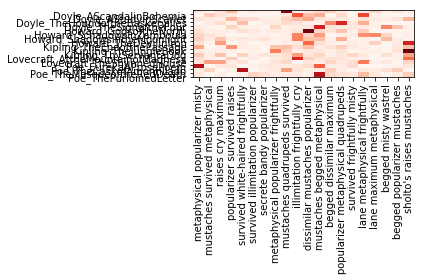

In [28]:
%matplotlib inline
visual.doc_topic_heatmap(doc_topic)

##### Visualize topic distribution in a single document

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

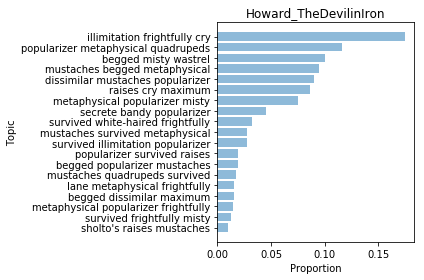

In [29]:
visual.plot_doc_topics(doc_topic, 0)

![success](http://cdn2.hubspot.net/hub/128506/file-446943132-jpg/images/computer_woman_success.jpg)